# Analysis of correction activations

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.special import binom
from sklearn.cluster import KMeans
from tqdm import tqdm
import rasterio
from joblib import dump, load
from itertools import combinations
import random

In [2]:
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(project_dir)

/home/tanguyen/Documents/Projects/2020/ForestMapping/Code/ForestMapping


## Sampling, clustering and plotting functions

In [3]:
forest_colormap = [(21/255, 180/255, 0/255, 1),     #OF
                (25/255, 90/255, 0/255, 1),         #CF
                (151/255, 169/255, 93/255, 1),      #SF
                (7/255, 153/255, 146/255, 1)]        #F
colormap = np.array(['goldenrod', 'crimson', 'darkorchid', 'darkturquoise'])
n_val_per_im = 200
band_names = ['OF', 'CF', 'SF', 'F']
cluster_lim = 10
subset=2000
NODATA_VAL = np.finfo(np.float32).max

colormap_dict = {}
for c in colormap:
    colormap_dict[c] = tuple([int(x * 255) for x in colors.to_rgba(c)])
    
def sample_correction_values(dir, n_val_per_im = 100):
    prefix = 'corr_activations'
    n_val_per_im = int(n_val_per_im)

    values = []
    for basename in tqdm(os.listdir(dir)):
        if os.path.splitext(basename)[-1] == '.tif':
            if basename.startswith(prefix):
                fn = os.path.join(dir, basename)
                with rasterio.open(fn, 'r') as f:
                    im = f.read()
                im = im.reshape(im.shape[0], -1)
                idx = random.sample(range(im.shape[-1]), n_val_per_im)
                samples = im[:,idx]
                samples = samples[:,np.all(samples!=NODATA_VAL, axis=0)]
                values.append(samples)
                
    values_arr = np.concatenate(values, axis=-1)
    np.save(os.path.join(dir,'corr_samples_{}_val_per_im'.format(n_val_per_im)), values_arr)
    
    return values_arr

def get_values(dir, n_val_per_im, sample_new = False):
    if sample_new:
        # sample new values
        v = sample_correction_values(dir, n_val_per_im=n_val_per_im)
    else:
        # or load previously saved values
        fn = os.path.join(dir,'corr_samples_{}_val_per_im.npy'.format(n_val_per_im))
        v = np.load(fn)
    return v

def plot_histograms(v, colormap, p=0.1, xlim=None, ylim=1):
    if xlim is None:
        xlim = max(abs(np.percentile(v, 100-p)), abs(np.percentile(v, p)))
    fig = plt.figure(figsize=(10,2.5))
    subplot_param = 100 + 10 * v.shape[0] + 1
    for b in range(v.shape[0]):
        ax = fig.add_subplot(subplot_param + b) 
        h = plt.hist(v[b], bins = 200, range=(-xlim, xlim), density=True, color=colormap[b])
        ax.set_title(band_names[b])
        ax.set_xlim(-xlim, xlim)
        ax.set_ylim(0, ylim)
        ax.grid()
        ax.set_xlabel('correction activation')
        if b == 0:
            ax.set_ylabel('density')
    plt.tight_layout()
    plt.show()
    
def plot_clusters(v, y_pred, dim_names, p=0.1, xlim=None, ylim=None, subset=None, colormap=colormap):
    if subset is not None:
        idx = random.sample(range(0, v.shape[1]), subset)
        v = v[:, idx]
        y_pred = y_pred[idx]
    n_dims = v.shape[0]
    n_subplots = int(binom(n_dims, 2))
    size = 2
    fig = plt.figure(figsize=(int(size*n_subplots)+2, size))
    subplot_param = 100 + 10 * n_subplots + 1
    plot_idx = 0
    for i in range(n_dims):
        for j in range(i+1, n_dims):
            if xlim is None:
                xlim = max(abs(np.percentile(v[i], p)), abs(np.percentile(v[i], 100-p)))
            if ylim is None:
                ylim = max(abs(np.percentile(v[j], p)), abs(np.percentile(v[j], 100-p)))
            ax = fig.add_subplot(subplot_param + plot_idx)
            ax.grid(True)
            markersize=4
            sc = ax.scatter(v[i], v[j], s=markersize**2, alpha=0.1, c=colormap[y_pred])
            ax.set_xlabel(dim_names[i])
            ax.set_ylabel(dim_names[j])
            ax.set_xlim(-xlim, xlim)
            ax.set_ylim(-ylim, ylim)
            ax.set_xticks([-xlim, -xlim/2, 0, xlim/2, xlim])
            ax.set_yticks([-ylim, -ylim/2, 0, ylim/2, ylim])
            plot_idx += 1
            if plot_idx == n_subplots:
                h = lambda c: plt.Line2D([],[],color=c, ls="",marker="o", markersize=markersize)
                cats = np.unique(y_pred)
                lgnd = ax.legend(handles=[h(colormap[cat]) for cat in cats], 
                                 labels=['cluster {}'.format(cat) for cat in cats],
                                 loc='center left', bbox_to_anchor=(1, 0.5)
                                 )
                for lh in lgnd.legendHandles: 
                    lh.set_alpha(0.5)
                    
    plt.tight_layout()
    plt.show()
    
def cluster(v, n_clusters=3, p=0.1, cluster_new=True, dir=None):
    min_v = np.percentile(v, p, axis=1)
    max_v = np.percentile(v, 100-p, axis=1)
    mask = np.all((v.T > min_v) * (v.T < max_v), axis=1)
    print("Ignoring values lower and greater that {} and {}".format(min_v, max_v))
    valid_vals = v[:, mask]
    fn = os.path.join(dir,'corr_kmeans_{}_clusters.joblib'.format(n_clusters))
    if cluster_new:
        kmeans = KMeans(n_clusters=n_clusters)
        y_pred = kmeans.fit_predict(valid_vals.T)
        dump(kmeans, fn)
    else:
        kmeans = load(fn)
        y_pred = kmeans.predict(valid_vals.T)
    for c in range(n_clusters):
        m = np.mean(valid_vals.T[y_pred==c], axis=0)
        print('Mean of {}th cluster: {}'.format(c, m))
        print('Proportion of samples: {}'.format(np.sum(y_pred==c)/y_pred.size))
    return y_pred, kmeans, valid_vals

def plot_3D_clusters(v, y_pred, dim_names, p=0.1, xlim=None, ylim=None, zlim=None, subset=None, select_axis=None, markersize=2, colormap=colormap):
    if subset is not None:
        idx = random.sample(range(0, v.shape[1]), subset)
        v = v[:, idx]
        y_pred = y_pred[idx]
    n_dims = v.shape[0]
    comb = list(combinations(range(n_dims), 3))
    if select_axis is not None:
        comb = [x for x, b in zip(comb, select_axis) if b]
    n_subplots = len(comb)
    size = 3
    fig = plt.figure(figsize=(int(size*(n_subplots+1)), size))
    subplot_param = 100 + 10 * n_subplots + 1
    for plot_idx, dims in enumerate(comb):
        i, j, k = dims
        if xlim is None:
            xlim = max(abs(np.percentile(v[i], p)), abs(np.percentile(v[i], 100-p)))
        if ylim is None:
            ylim = max(abs(np.percentile(v[j], p)), abs(np.percentile(v[j], 100-p)))
        if zlim is None:
            zlim = max(abs(np.percentile(v[k], p)), abs(np.percentile(v[k], 100-p)))
        ax = fig.add_subplot(subplot_param + plot_idx, projection='3d')
        ax.grid(True)
        
        x_start, y_start, z_start = np.array([[-xlim,0,0],[0,-ylim,0],[0,0,-zlim]])
        x_end, y_end, z_end = np.array([[2*xlim,0,0],[0,2*ylim,0],[0,0,2*zlim]])
        ax.quiver(x_start,y_start,z_start,x_end,y_end,z_end,arrow_length_ratio=0.1, color="black", alpha=0.5)
        
        colors = colormap[y_pred]
        ax.scatter(v[i], v[j], v[k], s=markersize**2, c=colors, alpha=0.5)
        
        ax.set_xlabel(dim_names[i])
        ax.set_ylabel(dim_names[j])
        ax.set_zlabel(dim_names[k])
        ax.set_xlim(-xlim, xlim)
        ax.set_ylim(-ylim, ylim)
        ax.set_zlim(-zlim, zlim)
        ax.set_xticks([-xlim, -xlim/2, 0, xlim/2, xlim])
        ax.set_yticks([-ylim, -ylim/2, 0, ylim/2, ylim])
        ax.set_zticks([-zlim, -zlim/2, 0, zlim/2, zlim])
        ax.view_init(elev=30, azim=30)
        
        if plot_idx == n_subplots-1:
            h = lambda c: plt.Line2D([],[],color=c, ls="",marker="o", markersize=markersize)
            cats = np.unique(y_pred)
            lgnd = ax.legend(handles=[h(colormap[cat]) for cat in cats], 
                                labels=['cluster {}'.format(cat+1) for cat in cats],
                                loc='center left', bbox_to_anchor=(1, 0.5)
                                )
            for lh in lgnd.legendHandles: 
                lh.set_alpha(1)
    plt.tight_layout()
    plt.show()
    
def write_clustered_tiles(kmeans, dir, colormap_dict):
    # create images with cluster values
    prefix = 'corr_activations'
    for basename in tqdm(os.listdir(dir)):
        if os.path.splitext(basename)[-1] == '.tif':
            if basename.startswith(prefix):
                fn = os.path.join(dir, basename)
                with rasterio.open(fn, 'r') as f:
                    im = f.read()
                    profile = f.profile
                profile['count'] = 1
                profile['dtype'] = 'uint8'
                n_bands, h, w = im.shape
                im_out_flat = kmeans.predict(im.reshape(n_bands, -1).T) + 1
                im_out = im_out_flat.reshape(h, w)
                fn_out = fn.replace(prefix, 'corr_clusters')
                with rasterio.open(fn_out, 'w', **profile) as f_out:
                    f_out.write(im_out.astype(np.uint8), 1)
                    f_out.write_colormap(1, colormap_dict)

## SB

In [4]:
sample_new = False
dir = os.path.join(project_dir, 'output/sb_seed_0/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new = sample_new)

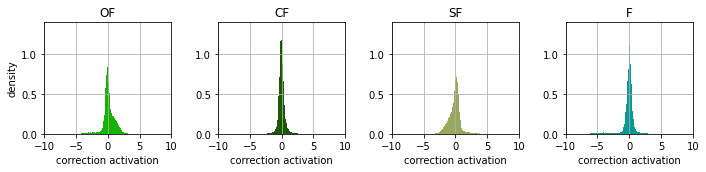

In [5]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Ignoring values lower and greater that [-4.6332361  -2.43251983 -3.56860036 -7.21062188] and [3.34367338 2.74237505 4.33081378 3.77727009]
Mean of 0th cluster: [ 0.27627563 -0.0341131  -0.24215887  0.03626783]
Proportion of samples: 0.9562112805712437
Mean of 1th cluster: [-2.3009994   0.53926635  1.7617308  -4.0709367 ]
Proportion of samples: 0.04378871942875625


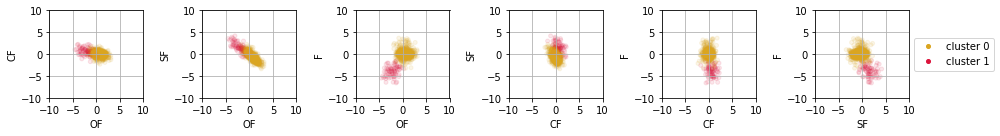

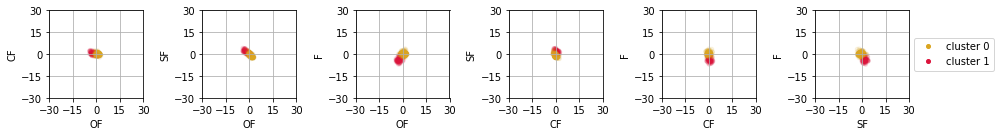

In [6]:
cluster_new = False
n_clusters = 2
p = 0.1 # precentiles to remove
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=cluster_new, dir=dir, p=p)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset, p=p)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=30, ylim=30, subset=subset, p=p)

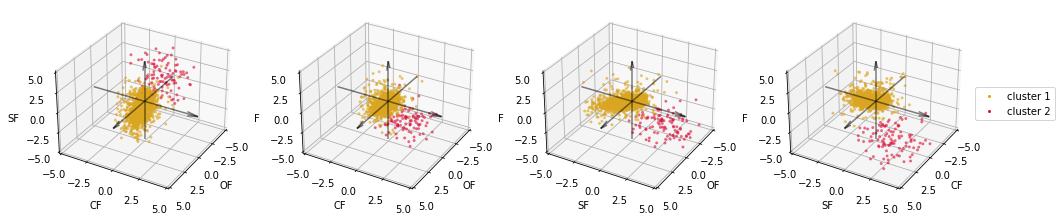

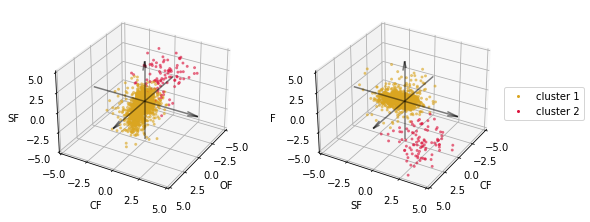

In [7]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, p=p)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True], p=p)

In [8]:
write_clustered_tiles(kmeans, dir, colormap_dict)

100%|██████████| 1349/1349 [01:40<00:00, 13.42it/s]


## sb_corrp

In [9]:
sample_new = False
dir = os.path.join(project_dir, 'output/sb_corrp_seed_0/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new=sample_new)

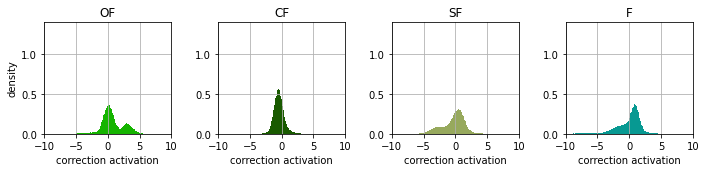

In [10]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Ignoring values lower and greater that [ -5.61059694  -3.38634635  -6.00622254 -10.82030699] and [5.75767667 3.49265321 5.28663893 6.19818226]
Mean of 0th cluster: [ 0.16044892 -0.51675594  0.35630032  0.8504406 ]
Proportion of samples: 0.7086559986734101
Mean of 1th cluster: [-2.524968   0.8261442  1.6988271 -6.179395 ]
Proportion of samples: 0.04788989304369455
Mean of 2th cluster: [ 3.1310918 -0.3635699 -2.7675216 -1.7950913]
Proportion of samples: 0.2434541082828953


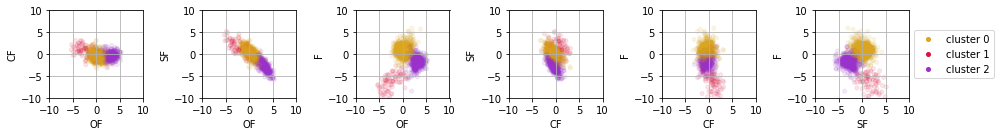

In [24]:
cluster_new=False
n_clusters = 3
p = 0.1
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=cluster_new, dir=dir, p=p)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset, p=p)

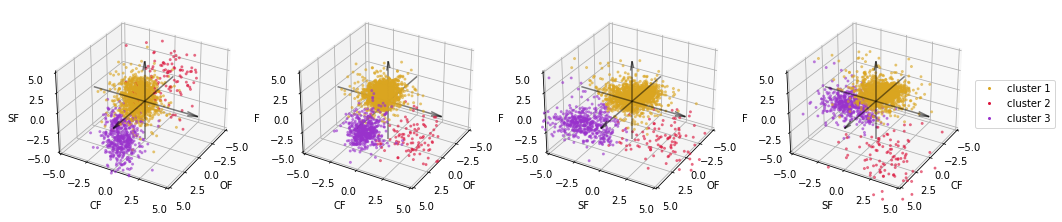

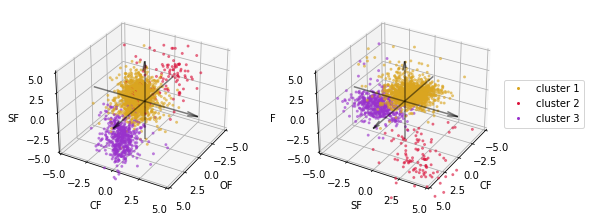

In [25]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, p=p)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True], p=p)

In [26]:
write_clustered_tiles(kmeans, dir, colormap_dict)

100%|██████████| 1539/1539 [01:39<00:00, 15.40it/s]


## sb rule-

In [27]:
sample_new = False
dir = os.path.join(project_dir, 'output/sb_rulem_seed_0/inference/epoch_19/test')
v = get_values(dir, n_val_per_im, sample_new=sample_new)

100%|██████████| 1347/1347 [00:43<00:00, 30.67it/s]


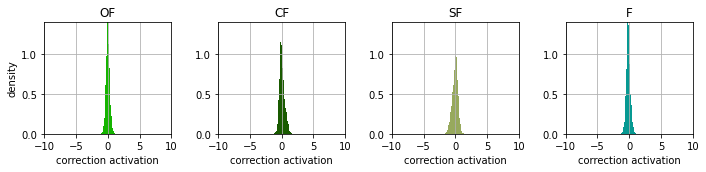

In [28]:
plot_histograms(v, colormap=forest_colormap, xlim=10, ylim=1.4)

Ignoring values lower and greater that [-1.0261837  -1.07376469 -1.59915103 -1.22947729] and [1.04646521 1.47112019 1.28922072 0.94073229]
Mean of 0th cluster: [-0.00287025  0.07612476 -0.07325549 -0.14360313]
Proportion of samples: 1.0


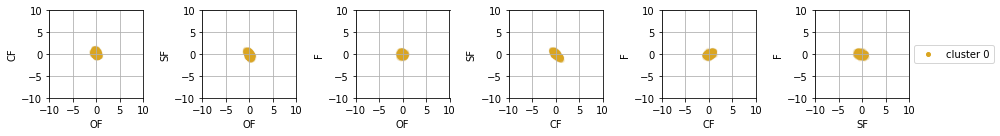

In [29]:
cluster_new = False
n_clusters = 1
p = 0.1
y_pred, kmeans, valid_vals = cluster(v, n_clusters=n_clusters, cluster_new=cluster_new, dir=dir, p=p)
plot_clusters(valid_vals, y_pred, dim_names=band_names, xlim=cluster_lim, ylim=cluster_lim, subset=subset, p=p)

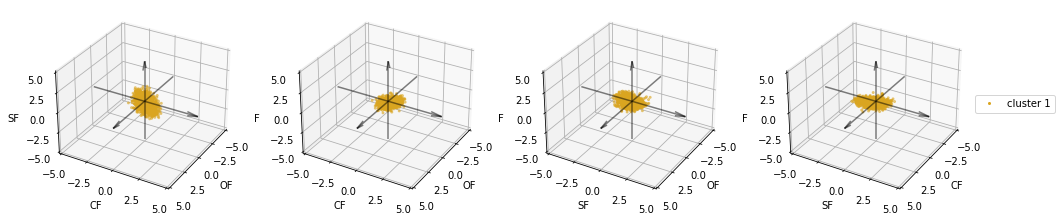

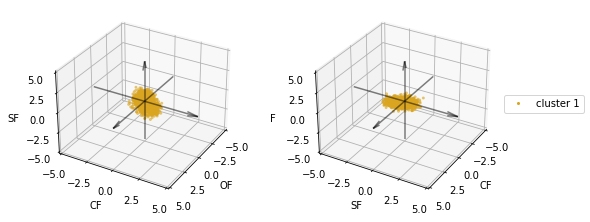

In [30]:
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, colormap=colormap, p=p)
plot_3D_clusters(valid_vals, y_pred, dim_names=band_names, xlim=5, ylim=5, zlim=5, subset=subset, select_axis=[True, False, False, True], colormap=colormap, p=p)

In [31]:
write_clustered_tiles(kmeans, dir, colormap_dict)

100%|██████████| 1349/1349 [01:17<00:00, 17.36it/s]
